# **Taller 7: Clasificación - Regresión logística y Bayes Ingenuo**

**Curso: 09481 - Inteligencia Artificial.**

**Universidad Icesi.**

**Profesor: Breyner Posso.**

**Estudiantes: Daniela Olarte y Alexander Sanchez.**

En la primera parte de este taller vamos a explorar la regresión logística y bayes ingenuo para problemas de clasificación binaria. En la segunda parte del taller vamos a explorar un subconjunto de un conjunto de datos para clasificación multiclase conocido como MNIST. Para abordar este problema utilizaremos la estrategia "uno contra todos" (one vs. all) también conocida como "uno contra el resto" (one vs. the rest).

# PARTE 1: Regresión logística para clasificación binaria.

# 0. Importar Librerías.

In [29]:
#Librerías de interés.
import pandas as pd                                   #Importamos la librería pandas. Nos va a servir para leer y manipular conjuntos de datos tabulares.
import matplotlib.pyplot as plt                       #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
from matplotlib.colors import LinearSegmentedColormap #Útil para definir un mapa de color por segmentos lineales. 
import numpy as np                                    #Importamos la librería numpy para manipular arreglos. 
import seaborn as sns

#from google.colab import files                        #Esta librería nos sirve para cargar archivos desde el disco duro.

#!pip install sklearn --upgrade                       #En caso que requiera actualizar sklearn. 
from sklearn.model_selection import train_test_split  #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler        #Útil para escalar los atributos de entrada.
import sklearn.datasets as dt                         #Útil para crear datasets sintéticos para hacer pruebas. 
from sklearn.linear_model import LogisticRegression   #Modelo de regresión logística para clasificación. 
from sklearn import metrics                           #Permite calcular algunas métricas de desempeño.

from copy import deepcopy                             #Permite hacer copias profundas.
from sklearn.linear_model import LogisticRegression 

# 1. Cargar Datos.

https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

In [30]:
#df = pd.read_csv('water_potability.csv')
df = pd.read_csv('breast_cancer_wisconsin.csv')

# 2. Análisis Exploratorio de Datos.

### Información Básica del Dataset

In [31]:
df['diagnosis'] = df['diagnosis'].astype('category')

In [32]:
df = df.replace(['M','B'],[1,0])

In [33]:
df['diagnosis'] = df['diagnosis'].astype(int)

### Distribución de la Variable Target

Conteo de objetos por clase:
0    357
1    212
Name: diagnosis, dtype: int64



<AxesSubplot:ylabel='diagnosis'>

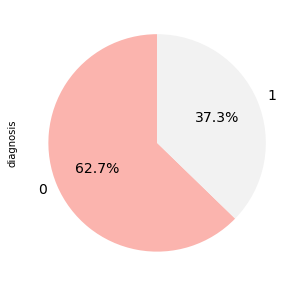

In [34]:
#Econtremos cómo están repartidas las categorías en el conjunto de datos. 
Target = 'diagnosis'
conteo_de_ejemplos_por_clase = df[Target].value_counts()
print('Conteo de objetos por clase:\n', conteo_de_ejemplos_por_clase, '\n',sep='')
#print('El tipo de este objeto es: ', type(conteo_de_ejemplos_por_clase),'\n')

#Revisemos esta información de forma gráfica.
#-------------------------------------------------------------------------------
#Opción 1: usemos un gráfico tipo pastel desde pandas. 
#-------------------------------------------------------------------------------
conteo_de_ejemplos_por_clase.plot(kind='pie', 
                                    figsize=(5, 5),
                                    autopct='%1.1f%%',  #Esto muestra úicamente el porcentaje de ejemplos de cada categoría en el gráfico. 
                                    #autopct=lambda pct: '{:.1f}%\n({:d})'.format(pct, int(pct/100.*conteo_de_ejemplos_por_clase.sum())), #Con esta función lambda se puede mostrar el porcentaje y el número absoluto de ejemplos en cada categoría. 
                                    startangle=90,       #Esto define la orientación de la línea vertical inicial de las divisiones del pie chart.
                                    fontsize=14,         #Tamaño de los textos.         
                                    cmap='Pastel1')      #Para otros color maps visite: https://matplotlib.org/stable/tutorials/colors/colormaps.html


In [35]:
df_clean = deepcopy(df.iloc[:,1:12])
print(type(df_clean))
print(df_clean.shape)

<class 'pandas.core.frame.DataFrame'>
(569, 11)


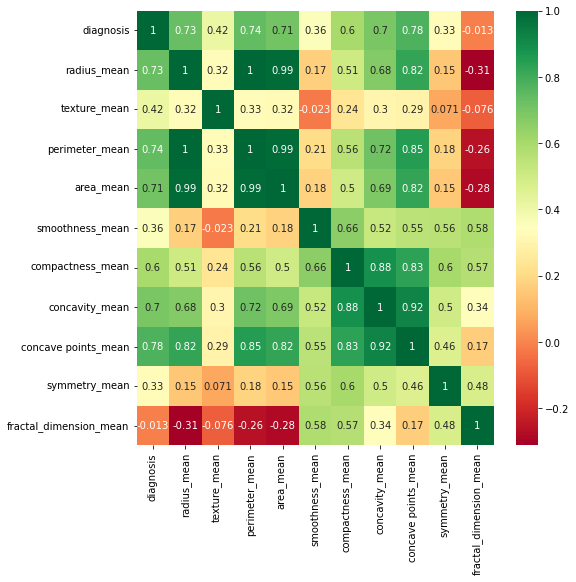

In [36]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_clean.corr(),annot=True,cmap='RdYlGn')

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def curva_roc(y_prob, df_y):
    
    ns_prob = [0 for _ in range(len(df_y))]

    # keep probabilities for the positive outcome only
    y_prob_val_c1 = y_prob[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(df_y, ns_prob)
    log_reg_auc = roc_auc_score(df_y, y_prob_val_c1)

    # summarize scores
    print('No Skill: ROC AUC=%.4f' % (ns_auc))
    print('Logistic: ROC AUC=%.4f' % (log_reg_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(df_y, ns_prob)
    log_reg_fpr, log_reg_tpr, ths = roc_curve(df_y, y_prob_val_c1)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'b', label='No Skill')
    plt.plot(log_reg_fpr, log_reg_tpr, marker='.', color = 'r', label='Logistic')

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return ths

In [38]:
# keep probabilities for the positive outcome only

def umbral_optimo(y_prob,df_y,ths):
    
    y_prob_c1 = y_prob[:, 1]
    roc = []
    for j in range (len(ths)):
        y_pred = np.zeros(len(y_prob_c1))
        for i in range(len(y_prob_c1)):
            if (y_prob_c1[i] >= ths[j]):
                y_pred[i] = 1
        cm = metrics.confusion_matrix(df_y,y_pred)
        TP = cm[1,1]
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        roc.append((TPR,FPR,ths[j]))    

    roc = np.array(roc)  
    
    distance_to_top_left_corner = []

    for i in range(len(roc)):
        distance_to_top_left_corner.append( np.sqrt( ((roc[i,1]-0)**2)+((roc[i,0]-1)**2) ) )

    index_of_best_threshold = distance_to_top_left_corner.index(min(distance_to_top_left_corner)) #Retorna el índice con la menor distancia
    best_threshold          = ths[index_of_best_threshold]
    #print('El mejor umbral para el conjunto de validación es {:.4f}.'.format(best_threshold))
    return best_threshold

## Selección de Predictores

In [39]:
#Nombre de la salida deseada:
nombre_de_la_variable_de_salida='diagnosis' 

#Nombre de los posibles atributos de entrada:
# 1   diagnosis                569 non-null    object 
# 2   radius_mean              569 non-null    float64
# 3   texture_mean             569 non-null    float64
# 4   perimeter_mean           569 non-null    float64
# 5   area_mean                569 non-null    float64
# 6   smoothness_mean          569 non-null    float64
# 7   compactness_mean         569 non-null    float64
# 8   concavity_mean           569 non-null    float64
# 9   concave points_mean      569 non-null    float64
# 10  symmetry_mean            569 non-null    float64
# 11  fractal_dimension_mean   569 non-null    float64

nombre_de_las_variables_de_entrada = ['perimeter_mean','concave points_mean']
df_y = df_clean[nombre_de_la_variable_de_salida]

df_x = deepcopy(df_clean[nombre_de_las_variables_de_entrada])

In [40]:
# Vamos a dividir los datos en un conjunto de entrenamiento, un conjunto de desarrollo o validación, y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 42
4#Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script. 

#Porcentajes de división de datos. 
particion_para_entrenamiento = 0.6  #Dejamos el 60% de los datos para el conjunto de entrenamiento (training set).
particion_para_desarrollo    = 0.2  #Dejamos el 20% de los datos para el conjunto de desarrollo (dev set).
                                    #Este conjunto se conoce también como: selección del modelo, validación, o hold-out.
particion_para_entrenamiento_y_desarrollo = particion_para_entrenamiento+particion_para_desarrollo #Variable auxiliar. 
particion_para_pruebas       = 1.0-particion_para_entrenamiento_y_desarrollo #Dejamos los otros datos, correspondiente al 20%, para el conjunto de pruebas. 

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_rest, df_x_test, df_y_rest, df_y_test = train_test_split(df_x,                                         #100% de los datos de entrada. 
                                                              df_y,                                         #100% de los datos de salida. 
                                                              test_size=particion_para_pruebas, 
                                                              random_state=valor_semilla_aleatoria, 
                                                              shuffle=mezclar_los_datos)

#Del "resto" obtenemos los conjuntos de entrenamiento y desarrollo. 
df_x_train, df_x_val, df_y_train, df_y_val = train_test_split(df_x_rest,                                    #Una fracción de los datos de entrada. 
                                                              df_y_rest,                                    #Una fracción de los datos de salida.        
                                                              test_size=particion_para_desarrollo/particion_para_entrenamiento_y_desarrollo, #cuidado! este es el porcentaje respecto al "resto". 
                                                              random_state=valor_semilla_aleatoria, 
                                                              shuffle=False) #Los datos ya se mezclaron arriba, no es necesario repetirlo acá.  


In [41]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scale=StandardScaler()
df_x_train=scale.fit_transform(df_x_train)
df_x_val=scale.transform(df_x_val)
df_x_test=scale.transform(df_x_test)

## **Ejercicio 1.**

Usando Regresión Logística entrene diferentes modelos usando varias combinaciones de predictores. La idea es superar el resultado obtenido con el modelo usado en clase y además usar la menor cantidad de predictores posible.

Use los protocolos de evaluación train/val/test y/o cross-validation para determinar la mejor combinación de atributos.

Consigne todo el procedimiento llevado a cabo para construir el modelo final.

Tenga en cuenta que puede normalizar los atributos, procesar outliers, etc.

Reporte el desempeño del clasificador escogido usando el conjunto de prueba.

In [42]:
log_reg_1 = LogisticRegression()

## Baseline

In [43]:
count_p = (df_clean[Target] == 1).sum()
count_n = (df_clean[Target] == 0).sum()

print("Línea Base: %.2f" % (100*max(count_n,count_p)/(count_p+count_n)))

Línea Base: 62.74


No Skill: ROC AUC=0.5000
Logistic: ROC AUC=0.9749


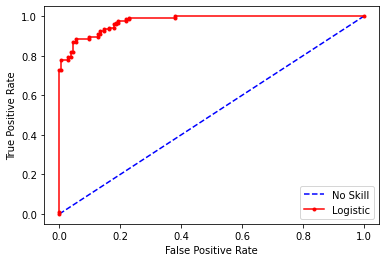

El mejor umbral es 0.3679.


In [44]:
log_reg_1.fit(df_x_train,df_y_train)
y_prob = log_reg_1.predict_proba(df_x_train)
ths = curva_roc(y_prob,df_y_train)
best_th = umbral_optimo(y_prob,df_y_train,ths)
print('El mejor umbral es {:.4f}.'.format(best_th))

Accuracy: 0.9238
TPR: 0.8852
FPR: 0.0548


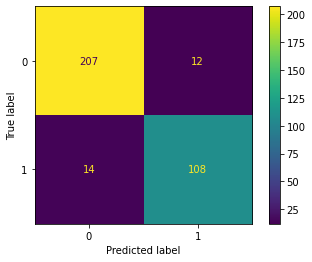

In [45]:
# predict probabilities on the training set
y_prob = log_reg_1.predict_proba(df_x_train)

# predict class
y_prob_c1 = y_prob[:, 1]
th = best_th
y_pred = np.zeros(len(y_prob_c1))
for i in range(len(y_prob_c1)):
    if (y_prob_c1[i] >= th):
        y_pred[i] = 1

#Evaluation on the training set
cm = metrics.confusion_matrix(df_y_train,y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
acc = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy: %.4f' % acc)
print('TPR: %.4f' % TPR)
print('FPR: %.4f' % FPR)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

Accuracy: 0.9298
TPR: 0.9149
FPR: 0.0597


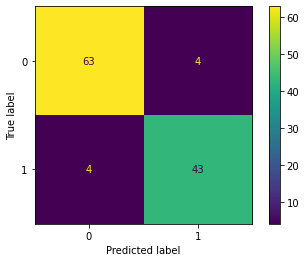

In [46]:
# predict probabilities on the validation set
y_prob = log_reg_1.predict_proba(df_x_val)

# predict class
y_prob_c1 = y_prob[:, 1]
th = best_th
y_pred = np.zeros(len(y_prob_c1))
for i in range(len(y_prob_c1)):
    if (y_prob_c1[i] >= th):
        y_pred[i] = 1

#Evaluation on the training set
cm = metrics.confusion_matrix(df_y_val,y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
acc = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy: %.4f' % acc)
print('TPR: %.4f' % TPR)
print('FPR: %.4f' % FPR)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

## **Ejercicio 2.**

Usando Bayes Ingenuo entrene diferentes modelos usando varias combinaciones de predictores. La idea es superar el resultado obtenido con el modelo usado en clase y además usar la menor cantidad de predictores posible.

Use los protocolos de evaluación train/val/test y/o cross-validation para determinar la mejor combinación de atributos.

Consigne todo el procedimiento llevado a cabo para construir el modelo final.

Tenga en cuenta que puede normalizar los atributos, procesar outliers, etc.

Reporte el desempeño del clasificador escogido usando el conjunto de prueba.

In [47]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

In [48]:
gnb.fit(df_x_train, df_y_train)

GaussianNB()

No Skill: ROC AUC=0.5000
Logistic: ROC AUC=0.9750


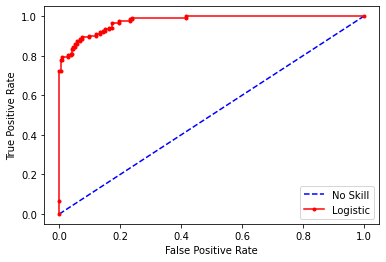

El mejor umbral es 0.2314.


In [49]:
y_prob = gnb.predict_proba(df_x_train)
ths = curva_roc(y_prob,df_y_train)
best_th = umbral_optimo(y_prob,df_y_train,ths)
print('El mejor umbral es {:.4f}.'.format(best_th))

Accuracy: 0.9150
TPR: 0.8934
FPR: 0.0731


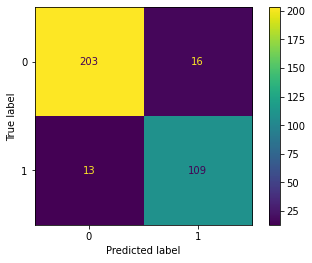

In [50]:
# predict probabilities on the training set
y_prob = gnb.predict_proba(df_x_train)

# predict class
y_prob_c1 = y_prob[:, 1]
th = best_th
y_pred = np.zeros(len(y_prob_c1))
for i in range(len(y_prob_c1)):
    if (y_prob_c1[i] >= th):
        y_pred[i] = 1

#Evaluation on the training set
cm = metrics.confusion_matrix(df_y_train,y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
acc = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy: %.4f' % acc)
print('TPR: %.4f' % TPR)
print('FPR: %.4f' % FPR)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

Accuracy: 0.9386
TPR: 0.9362
FPR: 0.0597


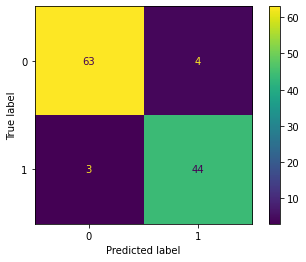

In [51]:
# predict probabilities on the validation set
y_prob = gnb.predict_proba(df_x_val)

# predict class
y_prob_c1 = y_prob[:, 1]
th = best_th
y_pred = np.zeros(len(y_prob_c1))
for i in range(len(y_prob_c1)):
    if (y_prob_c1[i] >= th):
        y_pred[i] = 1

#Evaluation on the training set
cm = metrics.confusion_matrix(df_y_val,y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
acc = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy: %.4f' % acc)
print('TPR: %.4f' % TPR)
print('FPR: %.4f' % FPR)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

## **Ejercicio 3.**

Usando KNN entrene diferentes modelos usando varias combinaciones de predictores. La idea es superar el resultado obtenido con el modelo usado en clase y además usar la menor cantidad de predictores posible.

Use los protocolos de evaluación train/val/test y/o cross-validation para determinar la mejor combinación de atributos y del valor de K.

Consigne todo el procedimiento llevado a cabo para construir el modelo final.

Tenga en cuenta que puede normalizar los atributos, procesar outliers, etc.

Reporte el desempeño del clasificador escogido usando el conjunto de prueba.

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)

In [53]:
knn.fit(df_x_train, df_y_train)

KNeighborsClassifier(n_neighbors=2)

No Skill: ROC AUC=0.5000
Logistic: ROC AUC=0.9914


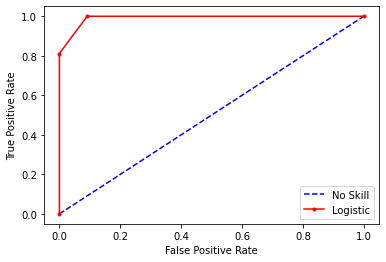

El mejor umbral es 0.5000.


In [54]:
y_prob = knn.predict_proba(df_x_train)
ths = curva_roc(y_prob,df_y_train)
best_th = umbral_optimo(y_prob,df_y_train,ths)
print('El mejor umbral es {:.4f}.'.format(best_th))

Accuracy: 0.9120
TPR: 0.8443
FPR: 0.0502


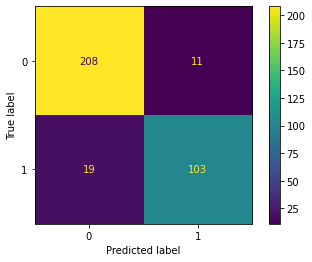

In [55]:
# predict probabilities on the training set
y_prob = gnb.predict_proba(df_x_train)

# predict class
y_prob_c1 = y_prob[:, 1]
th = best_th
y_pred = np.zeros(len(y_prob_c1))
for i in range(len(y_prob_c1)):
    if (y_prob_c1[i] >= th):
        y_pred[i] = 1

#Evaluation on the training set
cm = metrics.confusion_matrix(df_y_train,y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
acc = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy: %.4f' % acc)
print('TPR: %.4f' % TPR)
print('FPR: %.4f' % FPR)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

Accuracy: 0.9123
TPR: 0.8723
FPR: 0.0597


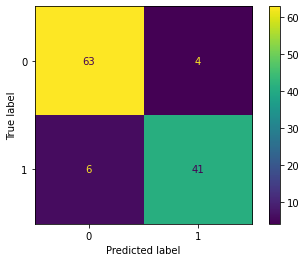

In [56]:
# predict probabilities on the validation set
y_prob = gnb.predict_proba(df_x_val)

# predict class
y_prob_c1 = y_prob[:, 1]
th = best_th
y_pred = np.zeros(len(y_prob_c1))
for i in range(len(y_prob_c1)):
    if (y_prob_c1[i] >= th):
        y_pred[i] = 1

#Evaluation on the training set
cm = metrics.confusion_matrix(df_y_val,y_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
acc = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy: %.4f' % acc)
print('TPR: %.4f' % TPR)
print('FPR: %.4f' % FPR)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

## **Ejercicio 4.**

Aplique la regresión logística multinomial al conjunto de datos MNIST de entrenamiento y reporte sus métricas sobre el conjunto de datos de pruebas. Compare los resultados con los que obtuvo cuando usamos la estrategia "uno contra todos".

**Clasificación multiclase usando regresión logística multinomial, también conocida como regresión softmax.**

$K$: Número de categorías.

$i, k$: Variables auxiliares que usaremos para indexar los clasificadores.

${\left( {} \right)^{\left( j \right)}}$: Variable auxiliar que emplearemos para indexar las observaciones.

$n$: Número de atributos de entrada.

**Ecuaciones:**

\begin{equation}
{z_i}^{\left( j \right)} = {{\bf{w}}_i}^T{{\bf{x}}^{\left( j \right)}}\\
\end{equation}

Vector de pesos del $i$-ésimo clasificador.

\begin{equation}
{{\bf{w}}_i} = {\left[ {\begin{array}{*{20}{c}}
{{w_{i,0}},}&{{w_{i,1}},}&{{w_{i,2}},}& \ldots &{{,w_{i,n}}}
\end{array}} \right]^T}\\
\end{equation}

$j$-ésimo vector de entrada:

\begin{equation}
{{\bf{x}}^{\left( j \right)}} = {\left[ {\begin{array}{*{20}{c}}
{1,}&{{x_1}^{\left( j \right)},}&{{x_2}^{\left( j \right)},}& \ldots &{{,x_n}^{\left( j \right)}}
\end{array}} \right]^T}\\
\end{equation}

Función softmax:

\begin{equation}
\begin{array}{*{20}{c}}
{{\rm{softmax}}\left( {{z_i}^{\left( j \right)}} \right) = \frac{{{e^{{{{z_i}^{\left( j \right)}}}}}}}{{\sum\limits_{k = 1}^K {{e^{{z_k}^{\left( j \right)}}}} }}}&{{\rm{donde: }}~1 \le i\le K\\}
\end{array} 
\end{equation}

Predicción de un sólo clasificador:

\begin{equation}
{y_{pred}}\left( {{z_i}^{\left( j \right)}} \right) = {\rm{softmax}}\left( {{z_i}^{\left( j \right)}} \right) = {\rm{softmax}}\left( {{\bf{w}}_i}^T{{\bf{x}}^{\left( j \right)}} \right) = \frac{{{e^{{{\bf{w}}_i}^T{{\bf{x}}^{\left( j \right)}}}}}}{{\sum\limits_{k = 1}^K {{e^{{{\bf{w}}_k}^T{{\bf{x}}^{\left( j \right)}}}}} }}
\end{equation}

Predicción de todos los clasificadores:

\begin{equation}
{y_{pred}}\left( {{{\bf{z}}^{\left( j \right)}}} \right) = {\rm{softmax}}\left( {{ {\bf{z}}^{\left( j \right) }}} \right) = {\left[ {\begin{array}{*{20}{c}}
{\frac{{{e^{{z_1}^{\left( j \right)}}}}}{{\sum\limits_{k = 1}^K {{e^{{z_k}^{\left( j \right)}}}} }},}&{\frac{{{e^{{z_2}^{\left( j \right)}}}}}{{\sum\limits_{k = 1}^K {{e^{{z_k}^{\left( j \right)}}}} }},}& \ldots &{\frac{{{e^{{z_K}^{\left( j \right)}}}}}{{\sum\limits_{k = 1}^K {{e^{{z_k}^{\left( j \right)}}}} }}}
\end{array}} \right]^T}\\
\end{equation}


¿Qué características tiene la clasificación logística multinomial?
1.  Permite abordar la clasificación multiclase.
2.  Las predicciones siempre son mayores o iguales que cero.
3.  La suma de las predicciones es igual a 1.
4. Debido a los puntos 2 y 3, podemos interpretar sus salidas como si fueran probabilidades.

**Nota:** Al igual que la función sigmoide, la función softmax tiene la propiedad de "empujar" los valores hacia 0 o 1. Por lo tanto, si una de las entradas es mayor que las otras, tenderá a empujar su probabilidad hacia 1 y suprimir las probabilidades de las entradas más pequeñas. 

**Función de costo para la regresión logística multinomial:**

\begin{equation}
J\left( \bf{W} \right) =  - \sum\limits_{j = 1}^m {\sum\limits_{k = 1}^K {\left[ {1\left\{ {{y^{\left( j \right)}} = k} \right\}\log \left( {\frac{{{e^{{{\bf{w}}_k}^T{{\bf{x}}^{\left( j \right)}}}}}}{{\sum\limits_{q = 1}^K {{e^{{{\bf{w}}_q}^T{{\bf{x}}^{\left( j \right)}}}}} }}} \right)} \right]} }
\end{equation}

Donde: 
*  $\bf{W}$: es una matriz de coeficientes que agrupa todos los ${\bf{w}}_k$. 
* 1 {⋅} es la "función indicadora", de forma tal que 1{expresión verdadera} = 1, mientras que  1{expresión falsa} = 0. Por ejemplo, 1 {2 + 2 = 4} se evalúa como 1; mientras que 1 {1 + 1 = 5} se evalúa como 0.



**Observaciones:**
*   Debe indicarse que la solución al problema de minimización de la función de costo que se acaba de presentar, debe realizarse de forma iterativa, usando por ejemplo gradiente descendente u otro método numérico. En el enlace que se indica en la parte inferior puede encontrar la expresión del gradiente de la función de costo respecto a uno de los vector de parámetros ${\bf{w}}_k$ que hace parte de la matriz de parámetros $\bf{W}$. En la práctica, puede usar la clase LogisticRegression de la librería scickit-learn, invocando el constructor de la clase con los parámetros adecuados para 'multi_class', 'solver', y 'penalty' (que permite controlar la regularización). Por ejemplo:

`LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')`


*   La entropía cruzada (que corresponde a la función de costo en regresión logística), se puede representar como un caso especial de la función de costo que definimos para la regresión logística multinomial. En el siguiente enlace puede consultar cómo probar tal relación. 

http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model1 = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(df_x_train,df_y_train)
preds = model1.predict(df_x_test)

print('Intercept: \n', model1.intercept_)
print('Coefficients: \n', model1.coef_)
print("Confusion matrix :  \n " , confusion_matrix(df_y_test, preds))
print('Accuracy Score:', metrics.accuracy_score(df_y_test, preds))

class_report=classification_report(df_y_test, preds)
print(class_report)

Intercept: 
 [-0.37572811]
Coefficients: 
 [[1.12559414 1.44179127]]
Confusion matrix :  
  [[66  5]
 [ 5 38]]
Accuracy Score: 0.9122807017543859
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       0.88      0.88      0.88        43

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



De los resultados obtenidos de vemos que la clasificacion multinomial tiene unos porcentajes de accuracy mucho mayores a los obtenidos por el one vs all. Esto se puede evidenciar en la presición, recall y acuracy donde la clasificacion multinomial es superior en este caso.